In [1]:
import sqlite3
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from utils.disgreement_utils import get_staple_eval_data, build_annotator_performance_df
from utils.performance_utils import get_prevalences_as_sample_avg_df, get_bias_column, get_ppv_column, get_cdf_comparison_visualization_df

import SimpleITK as sitk

In [2]:
params = {
    'axes.labelsize'  : 15.5,
    "font.family": "sans-serif",
    'axes.titlesize'  : 15.5,
    'font.size'       : 14,
    'legend.fontsize' : 11,
    'xtick.labelsize' : 13,
    'ytick.labelsize' : 13
}
plt.rcParams.update(params)

# tex_fonts = {
#     # Use LaTeX to write all text
#     "text.usetex": True,
#     "font.family": "serif",
#     # Use 10pt font in plots, to match 10pt font in document
#     "axes.labelsize": 14.5,
#     "font.size": 14.5,
#     # Make the legend/label fonts a little smaller
#     "legend.fontsize": 14.5,
#     "xtick.labelsize": 14.5,
#     "ytick.labelsize": 14.5
# }

# plt.rcParams.update(tex_fonts)

plt.rcParams.update({'figure.max_open_warning': 0})

In [3]:
img_id_ordered = ['lym0', 'lym17', 'neu0', 'neu12', 'neu90', 'agg17', 'agg23', 'agg185', 'neurblas5', 'neurblas10', 'neurblas16', 'normal2', 'normal4']

## *RQ3*: How much do different annotators (dis-)agree with each other w.r.t. their personal perceptions of segmentation quality?

In [4]:
conn = sqlite3.connect('grabcutstudy.db')

grabcut_masks_df = pd.read_sql_query('''select * from interactionswithmask''', conn, parse_dates=['first_interaction_time', 'submission_time'])
respondents_df = pd.read_sql_query('''select session_id, academic_field from respondentswithsubmissions''', conn)
conn.close()

computed_masks_dict = np.load('testimages_seg.npz')

In [5]:
grabcut_masks_df = pd.merge(grabcut_masks_df, respondents_df, how='inner', on='session_id')

In [6]:
def idx_str_to_np_array(x):
    indices = [int(s) for s in x.split(',')]
    mask_array = np.empty((384, 512), dtype=np.uint8).ravel()
    mask_array.fill(0)
    mask_array[indices] = 1
    return mask_array.reshape((384, 512))


grabcut_masks_df['mask_arr'] = grabcut_masks_df['mask'].apply(idx_str_to_np_array)
del grabcut_masks_df['mask']

In [7]:
# grabcut_masks_df.loc[grabcut_masks_df['image_id'] == image_id, ['mask_arr', 'mask_uuid']]

In [8]:
masks, staple_eval_data = get_staple_eval_data(img_id_ordered, grabcut_masks_df, computed_masks_dict)

[*] lym0:	 4 STAPLE iterations.
[*] lym17:	 3 STAPLE iterations.
[*] neu0:	 34 STAPLE iterations.
[*] neu12:	 9 STAPLE iterations.
[*] neu90:	 23 STAPLE iterations.
[*] agg17:	 6 STAPLE iterations.
[*] agg23:	 12 STAPLE iterations.
[*] agg185:	 12 STAPLE iterations.
[*] neurblas5:	 11 STAPLE iterations.
[*] neurblas10:	 10 STAPLE iterations.
[*] neurblas16:	 14 STAPLE iterations.
[*] normal2:	 9 STAPLE iterations.
[*] normal4:	 18 STAPLE iterations.


In [9]:
annotator_performance_df = build_annotator_performance_df(img_id_ordered, staple_eval_data)

In [10]:
conn = sqlite3.connect('grabcutstudy.db')
images_df = pd.read_sql_query('''select * from images''', conn)
conn.close()

In [11]:
masks_to_academic_field = grabcut_masks_df[['mask_uuid', 'academic_field']].copy()

annotator_performance_df = pd.merge(annotator_performance_df, images_df, how='inner', on='image_id')
annotator_performance_df = pd.merge(annotator_performance_df, masks_to_academic_field, how='inner', on='mask_uuid')

difficulty_levels = ['Easy', 'Medium', 'Noisy', 'Difficult']
difficulty = pd.api.types.CategoricalDtype(ordered=True, categories=difficulty_levels)
annotator_performance_df['difficulty'] = annotator_performance_df['difficulty'].astype(difficulty)

In [12]:
prevalences_df = get_prevalences_as_sample_avg_df(img_id_ordered, grabcut_masks_df, computed_masks_dict)
annotator_performance_df = pd.merge(annotator_performance_df, prevalences_df, how='inner', on='image_id')
annotator_performance_df['bias'] = get_bias_column(annotator_performance_df)
annotator_performance_df['ppv'] = get_ppv_column(annotator_performance_df)

# Sensitivity and Specificity boxplots per test image

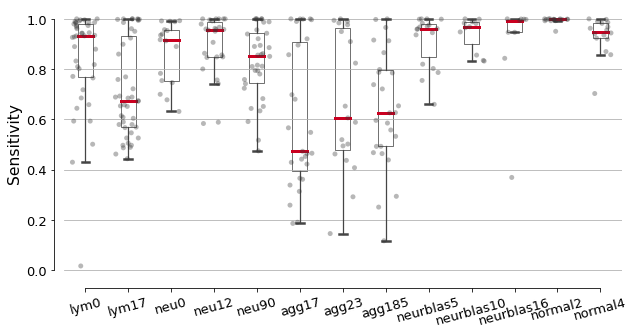

<Figure size 432x288 with 0 Axes>

In [13]:
sns.set_style({
    'xtick.top': False,
    'ytick.right': False,
})

f, ax = plt.subplots(figsize=(10, 5))

PROPS = {
    'boxprops':{'facecolor':'none'},
    'medianprops':{'color':'#ca0020', 'linewidth': 3},
    'whiskerprops':{'linewidth': 1.25},
    'capprops':{'linewidth': 2.5}
}

sns.boxplot(x='image_id', y='sensitivity', data=annotator_performance_df, showfliers = False, width=.35, whis=1.8, linewidth=0.75, **PROPS)

sns.stripplot(x='image_id', y='sensitivity', data=annotator_performance_df, size=5, color=".2", alpha=.35, jitter=0.3)

ax.yaxis.grid(True)
ax.set(ylabel="Sensitivity")
ax.set(xlabel="")
sns.despine(offset=10, trim=True)
plt.xticks(rotation=15)
plt.show()
plt.savefig(f"plots/sensitivities.png", bbox_inches='tight')

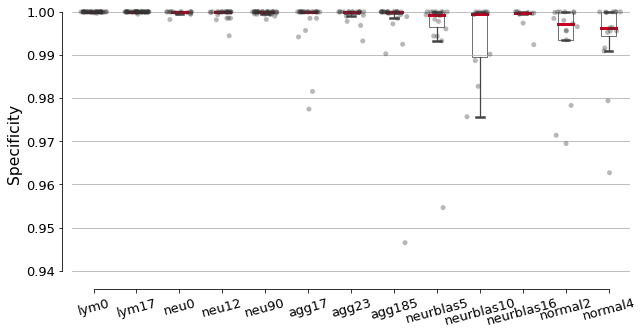

<Figure size 432x288 with 0 Axes>

In [14]:
sns.set_style({
    'xtick.top': False,
    'ytick.right': False,
})

f, ax = plt.subplots(figsize=(10, 5))

PROPS = {
    'boxprops':{'facecolor':'none'},
    'medianprops':{'color':'#ca0020', 'linewidth': 3},
    'whiskerprops':{'linewidth': 1.25},
    'capprops':{'linewidth': 2.5}
}

sns.boxplot(x='image_id', y='specificity', data=annotator_performance_df, showfliers = False, width=.35, whis=1.8, linewidth=0.75, **PROPS, ax=ax)

sns.stripplot(x='image_id', y='specificity', data=annotator_performance_df, size=5, color=".2", alpha=.35, jitter=0.3, ax=ax)

ax.set_ylim([0.938, 1.001])
ax.yaxis.grid(True, which="both")
ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
ax.set_yticks(np.arange(0.94, 1.0, step=0.01))

ax.set(ylabel="Specificity")
ax.set(xlabel="")
ax.spines['left'].set_visible(True)
sns.despine(offset=10, trim=True)
plt.xticks(rotation=15)
plt.show()

plt.savefig(f"plots/all_specificities.png", bbox_inches='tight')

# Sensitivity and Specificity boxplots per image difficulty category

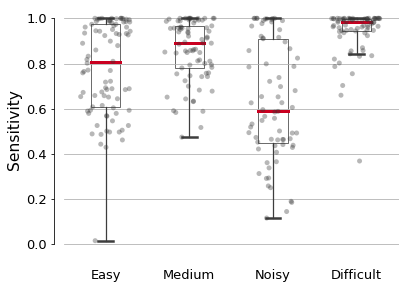

In [15]:
sns.set_style({
    'xtick.top': False,
    'ytick.right': False,
    'xtick.bottom': False,
})

f, ax = plt.subplots(1, 1, figsize=(6, 4.5))

PROPS = {
    'boxprops':{'facecolor':'none'},
    'medianprops':{'color':'#ca0020', 'linewidth': 3},
    'whiskerprops':{'linewidth': 1.25},
    'capprops':{'linewidth': 2.5}
}

sns.boxplot(x='difficulty', y='sensitivity', data=annotator_performance_df, showfliers = False, width=.35, whis=1.8, linewidth=0.75, ax=ax, **PROPS)

sns.stripplot(x='difficulty', y='sensitivity', data=annotator_performance_df, size=5, color=".2", alpha=.35, jitter=0.3, ax=ax)

ax.yaxis.grid(True)
ax.set(ylabel="Sensitivity")
ax.set(xlabel="")
ax.spines['bottom'].set_visible(False)

sns.despine(offset=10, trim=True)
ax.spines['bottom'].set_visible(False)

# plt.xticks(rotation=15)
plt.savefig('plots_png/sensitivitydifficulty.png', bbox_inches='tight')
plt.savefig(f"plots_png_higher_res/sensitivitydifficulty.png", dpi=1000, bbox_inches='tight')
plt.savefig(f"plots_pdf/sensitivitydifficulty.pdf", format='pdf', bbox_inches='tight')

plt.show()

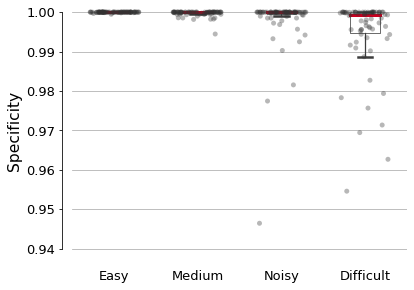

In [16]:
sns.set_style({
    'xtick.top': False,
    'ytick.right': False,
    'xtick.bottom': False,
})

f, ax = plt.subplots(1, 1, figsize=(6, 4.5))

PROPS = {
    'boxprops':{'facecolor':'none'},
    'medianprops':{'color':'#ca0020', 'linewidth': 3},
    'whiskerprops':{'linewidth': 1.25},
    'capprops':{'linewidth': 2.5}
}

sns.boxplot(x='difficulty', y='specificity', data=annotator_performance_df, showfliers = False, width=.35, whis=1.8, linewidth=0.75, ax=ax, **PROPS)

sns.stripplot(x='difficulty', y='specificity', data=annotator_performance_df, size=5, color=".2", alpha=.35, jitter=0.3, ax=ax)

ax.yaxis.grid(True)
ax.set(ylabel="Specificity")
ax.set(xlabel="")
ax.spines['bottom'].set_visible(False)

ax.set_ylim([0.939, 1.001])
sns.despine(offset=10, trim=True)
ax.spines['bottom'].set_visible(False)

plt.savefig('plots_png/specificitydifficulty.png', bbox_inches='tight')
plt.savefig(f"plots_png_higher_res/specificitydifficulty.png", dpi=1000, bbox_inches='tight')
plt.savefig(f"plots_pdf/specificitydifficulty.pdf", format='pdf', bbox_inches='tight')
plt.show()

# CDF preparation for plotting

In [17]:
print('Median Specificity of human annotators')
print(annotator_performance_df.groupby(['difficulty'])['specificity'].median())

Median Specificity of human annotators
difficulty
Easy         1.000000
Medium       1.000000
Noisy        1.000000
Difficult    0.999357
Name: specificity, dtype: float64


In [18]:
sensitivities_difficulty_cdf, sensitivities_difficulty_cdf_df = get_cdf_comparison_visualization_df(
    annotator_performance_df,
    'sensitivity',
    'difficulty',
    difficulty_levels
)


        Building CDFs of sensitivity-values 
        for ['Easy', 'Medium', 'Noisy', 'Difficult'] in difficulty
    
[*] 84 values for difficulty: Easy
[*] 77 values for difficulty: Medium
[*] 72 values for difficulty: Noisy
[*] 71 values for difficulty: Difficult


In [19]:
specificities_difficulty_cdf, specificities_difficulty_cdf_df = get_cdf_comparison_visualization_df(
    annotator_performance_df,
    'specificity',
    'difficulty',
    difficulty_levels
)


        Building CDFs of specificity-values 
        for ['Easy', 'Medium', 'Noisy', 'Difficult'] in difficulty
    
[*] 84 values for difficulty: Easy
[*] 77 values for difficulty: Medium
[*] 72 values for difficulty: Noisy
[*] 71 values for difficulty: Difficult


In [20]:
sensitivities_academic_bg_cdf, sensitivities_academic_bg_cdf_df = get_cdf_comparison_visualization_df(
    annotator_performance_df,
    'sensitivity',
    'academic_field',
    ['Computer Science', 'Electrical and Computer Engineering', 'Chemical Engineering and Material Science', 'Medicine and Health Science']
)


        Building CDFs of sensitivity-values 
        for ['Computer Science', 'Electrical and Computer Engineering', 'Chemical Engineering and Material Science', 'Medicine and Health Science'] in academic_field
    
[*] 86 values for academic_field: Computer Science
[*] 70 values for academic_field: Electrical and Computer Engineering
[*] 30 values for academic_field: Chemical Engineering and Material Science
[*] 29 values for academic_field: Medicine and Health Science


In [21]:
specificities_academic_bg_cdf, specificities_academic_bg_cdf_df = get_cdf_comparison_visualization_df(
    annotator_performance_df,
    'specificity',
    'academic_field',
    ['Computer Science', 'Electrical and Computer Engineering', 'Chemical Engineering and Material Science', 'Medicine and Health Science']
)


        Building CDFs of specificity-values 
        for ['Computer Science', 'Electrical and Computer Engineering', 'Chemical Engineering and Material Science', 'Medicine and Health Science'] in academic_field
    
[*] 86 values for academic_field: Computer Science
[*] 70 values for academic_field: Electrical and Computer Engineering
[*] 30 values for academic_field: Chemical Engineering and Material Science
[*] 29 values for academic_field: Medicine and Health Science


In [22]:
ppv_difficulty_cdf, ppv_difficulty_cdf_df = get_cdf_comparison_visualization_df(
    annotator_performance_df,
    'ppv',
    'difficulty',
    difficulty_levels
)

ppv_academic_bg_cdf, ppv_academic_bg_cdf_df = get_cdf_comparison_visualization_df(
    annotator_performance_df,
    'ppv',
    'academic_field',
    ['Computer Science', 'Electrical and Computer Engineering', 'Chemical Engineering and Material Science', 'Medicine and Health Science']
)


        Building CDFs of ppv-values 
        for ['Easy', 'Medium', 'Noisy', 'Difficult'] in difficulty
    
[*] 84 values for difficulty: Easy
[*] 77 values for difficulty: Medium
[*] 72 values for difficulty: Noisy
[*] 71 values for difficulty: Difficult

        Building CDFs of ppv-values 
        for ['Computer Science', 'Electrical and Computer Engineering', 'Chemical Engineering and Material Science', 'Medicine and Health Science'] in academic_field
    
[*] 86 values for academic_field: Computer Science
[*] 70 values for academic_field: Electrical and Computer Engineering
[*] 30 values for academic_field: Chemical Engineering and Material Science
[*] 29 values for academic_field: Medicine and Health Science


# Comparing sensitivity values per image difficulty category

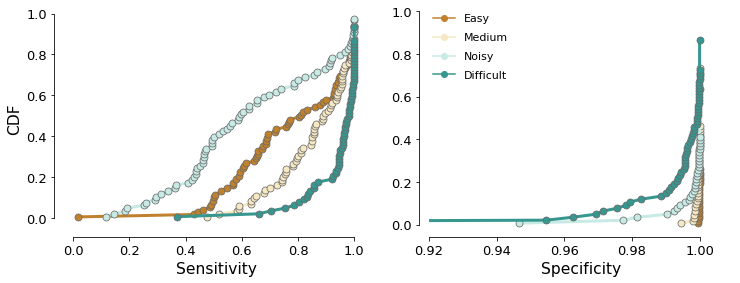

In [23]:
kromp_cmap = sns.color_palette("PRGn", 4)
# sns.palplot(kromp_cmap)

sns.set_style({
    'xtick.top': False,
    'ytick.right': False,
    'xtick.bottom': True,
})

f, ax = plt.subplots(1, 2, figsize=(12, 4))

marker_style={
    'markeredgecolor': 'dimgrey'
}

sns.lineplot(
    data=sensitivities_difficulty_cdf_df,
    x='xs',
    y='ps',
    dashes=False,
    hue='difficulty', style='difficulty', ci=None, markers=['o', 'o', 'o', 'o'], linewidth=3, markersize=7, palette='BrBG', ax=ax[0], **marker_style
)

ax[0].set(ylabel="CDF")
ax[0].set(xlabel="Sensitivity")
ax[0].get_legend().remove()

sns.lineplot(
    data=specificities_difficulty_cdf_df,
    x='xs',
    y='ps',
    dashes=False,
    hue='difficulty', style='difficulty', ci=None, markers=['o', 'o', 'o', 'o'], linewidth=3, markersize=7, palette='BrBG', ax=ax[1], **marker_style
)

ax[1].set_ylim([-0.01, 1.01])
ax[1].set_xlim([0.92, 1.01])
ax[1].set(ylabel="")
ax[1].set(xlabel="Specificity")

l = plt.legend(loc='upper left', borderaxespad=0., labelspacing=0.8, frameon=False)

sns.despine(offset=10, trim=True)
plt.savefig('plots/sens_spec_cdfs.png', bbox_inches='tight')
plt.savefig(f"plots_png_higher_res/sens_spec_cdfs.png", dpi=1000, bbox_inches='tight')
plt.savefig(f"plots_pdf/sens_spec_cdfs.pdf", format='pdf', bbox_inches='tight')

plt.show()

In [24]:
s = 0.4
print(f'p_noisy(s <= {s}) = {sensitivities_difficulty_cdf[2].Prob(s)}')

s = 0.9
print(f'p_difficult(s > {s}) = {sensitivities_difficulty_cdf[3].Prob(s)}')

p_noisy(s <= 0.4) = 0.16666666666666666
p_difficult(s > 0.9) = 0.18309859154929578


# Comparing sensitivity value CDFs across TOP 4 highest represented academic background groups

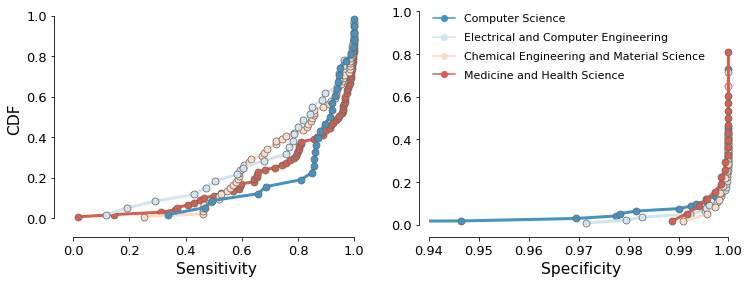

In [25]:
sns.set_style({
    'xtick.top': False,
    'ytick.right': False,
    'xtick.bottom': True,
})

f, ax = plt.subplots(1, 2, figsize=(12, 4))

marker_style={
    'markeredgecolor': 'dimgrey'
}

sns.lineplot(
    data=sensitivities_academic_bg_cdf_df,
    x='xs',
    y='ps',
    dashes=False,
    hue='academic_field', style='academic_field', ci=None, markers=['o', 'o', 'o', 'o'], linewidth=3, markersize=7, palette='RdBu', ax=ax[0], **marker_style
)

ax[0].set(ylabel="CDF")
ax[0].set(xlabel="Sensitivity")
ax[0].get_legend().remove()

sns.lineplot(
    data=specificities_academic_bg_cdf_df,
    x='xs',
    y='ps',
    dashes=False,
    hue='academic_field', style='academic_field', ci=None, markers=['o', 'o', 'o', 'o'], linewidth=3, markersize=7, palette='RdBu_r', ax=ax[1], **marker_style
)

ax[1].set_ylim([-0.01, 1.01])
ax[1].set_xlim([0.94, 1.001])
ax[1].set(ylabel="")
ax[1].set(xlabel="Specificity")

l = plt.legend(loc='upper left', borderaxespad=0., labelspacing=0.8, frameon=False)

sns.despine(offset=10, trim=True)

plt.savefig('plots/sens_spec_academ_cdfs.png', bbox_inches='tight')
plt.savefig(f"plots_png_higher_res/sens_spec_academ_cdfs.png", dpi=1000, bbox_inches='tight')
plt.savefig(f"plots_pdf/sens_spec_academ_cdfs.pdf", format='pdf', bbox_inches='tight')

plt.show()

# Comparing PPV value CDFs per image difficulty category

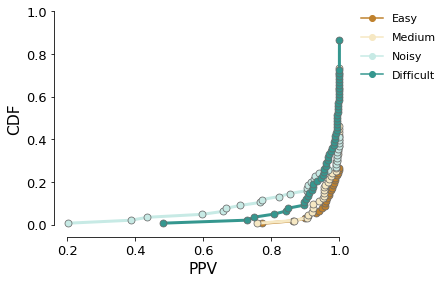

In [26]:
kromp_cmap = sns.color_palette("PRGn", 4)

sns.set_style({
    'xtick.top': False,
    'ytick.right': False,
    'xtick.bottom': True,
})

f, ax = plt.subplots(figsize=(5, 4))

ax.set_xlim([0.19, 1.01])
ax.set_ylim([-0.01, 1.01])

marker_style={
    'markeredgecolor': 'dimgrey'
}

sns.lineplot(data=ppv_difficulty_cdf_df, x='xs', y='ps',
             dashes=False,
             hue='difficulty', style='difficulty', ci=None, markers=['o', 'o', 'o', 'o'], linewidth=3, markersize=7, palette='BrBG', ax=ax, **marker_style)

l = plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., labelspacing=0.8, frameon=False)

ax.set(ylabel="CDF")
ax.set(xlabel="PPV")
sns.despine(offset=10, trim=True)

plt.savefig('plots/ppv_difficulty_cdfs.png', bbox_inches='tight')
plt.show()

# Comparing PPV value CDFs across TOP 4 highest represented academic background groups

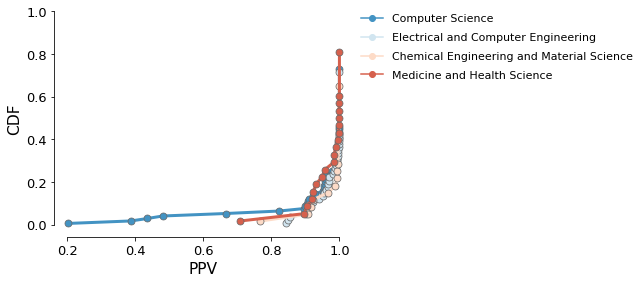

In [27]:
kromp_cmap = sns.color_palette("PRGn", 4)

sns.set_style({
    'xtick.top': False,
    'ytick.right': False,
})

f, ax = plt.subplots(figsize=(5, 4))

ax.set_xlim([0.19, 1.01])
ax.set_ylim([-0.01, 1.01])

marker_style={
    'markeredgecolor': 'dimgrey'
}

sns.lineplot(
    data=ppv_academic_bg_cdf_df,
    x='xs',
    y='ps',
    dashes=False,
    hue='academic_field', style='academic_field', ci=None, markers=['o', 'o', 'o', 'o'], linewidth=3, markersize=7, palette='RdBu_r', ax=ax, **marker_style
)

l = plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., labelspacing=0.8, frameon=False)

ax.set(ylabel="CDF")
ax.set(xlabel="PPV")
sns.despine(offset=10, trim=True)

plt.savefig('plots/ppv_academ_cdfs.png', bbox_inches='tight')
plt.savefig(f"plots_pdf/ppv_academ_cdfs.pdf", format='pdf', bbox_inches='tight')

plt.show()

In [28]:
annotator_performance_df.groupby(['academic_field']).mean()

,sensitivity,specificity,cell_count,prevalence,bias,ppv
academic_field,,,,,,
(Bio-)chemistry,0.768244,0.999824,6.058824,0.028051,0.024484,0.994314
Biology,0.811030,0.996716,7.125000,0.044210,0.045195,0.953398
Chemical Engineering and Material Science,0.759595,0.999273,6.433333,0.031665,0.028382,0.981672
"Civil-, Geo- and Environmental Engineering",0.690550,0.999992,5.000000,0.022383,0.018835,0.994851
Computer Science,0.826474,0.994470,6.662791,0.037417,0.039617,0.952694
Education Science,0.657762,0.998348,7.250000,0.035659,0.024946,0.958434
Electrical and Computer Engineering,0.793404,0.998611,6.600000,0.036074,0.034154,0.981158
"Humanities (e.g. Philosphy, Languages, Arts, Law)",0.851170,0.993264,6.375000,0.033597,0.037006,0.906887
Management and Business Studies,0.841138,0.998224,6.625000,0.034571,0.033749,0.913529


In [29]:
kromp_ids = ['neurblas5', 'neurblas10', 'neurblas16', 'normal2', 'normal4']

def has_kromp_id(x):
    return x in {'neurblas5', 'neurblas16', 'neurblas10', 'normal2', 'normal4'}

# kromp_masks_df = masks_df.loc[masks_df['image_id'] in kromp_ids]
annotator_performance_df = annotator_performance_df.assign(is_kromp_data=annotator_performance_df['image_id'].apply(has_kromp_id))
kromp_masks_df = annotator_performance_df[annotator_performance_df['is_kromp_data']]

In [30]:
sensitivity_kromp_cdf, sensitivity_kromp_cdf_df = get_cdf_comparison_visualization_df(
    annotator_performance_df,
    'sensitivity',
    'image_id',
    kromp_ids
)

specificity_kromp_cdf, specificity_kromp_cdf_df = get_cdf_comparison_visualization_df(
    annotator_performance_df,
    'specificity',
    'image_id',
    kromp_ids
)


        Building CDFs of sensitivity-values 
        for ['neurblas5', 'neurblas10', 'neurblas16', 'normal2', 'normal4'] in image_id
    
[*] 18 values for image_id: neurblas5
[*] 11 values for image_id: neurblas10
[*] 9 values for image_id: neurblas16
[*] 17 values for image_id: normal2
[*] 16 values for image_id: normal4

        Building CDFs of specificity-values 
        for ['neurblas5', 'neurblas10', 'neurblas16', 'normal2', 'normal4'] in image_id
    
[*] 18 values for image_id: neurblas5
[*] 11 values for image_id: neurblas10
[*] 9 values for image_id: neurblas16
[*] 17 values for image_id: normal2
[*] 16 values for image_id: normal4


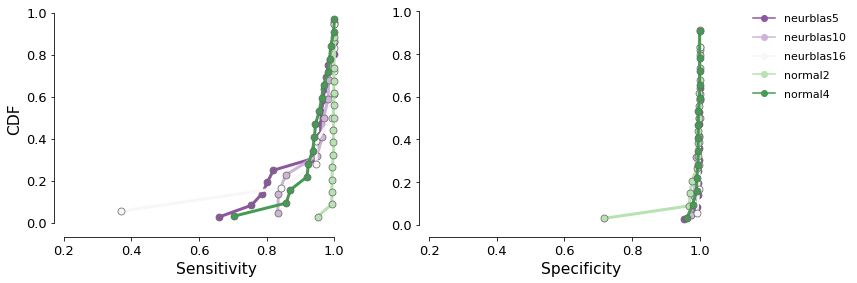

In [31]:
sns.set_style({
    'xtick.top': False,
    'ytick.right': False,
    'xtick.bottom': True,
})

f, ax = plt.subplots(1, 2, figsize=(12, 4))

marker_style={
    'markeredgecolor': 'dimgrey'
}

sns.lineplot(
    data=sensitivity_kromp_cdf_df,
    x='xs',
    y='ps',
    dashes=False,
    hue='image_id', style='image_id', ci=None, markers=['o', 'o', 'o', 'o', 'o'], linewidth=3, markersize=7, palette='PRGn', ax=ax[0], **marker_style
)

ax[0].set_xlim([0.2, 1.1])
ax[0].set(ylabel="CDF")
ax[0].set(xlabel="Sensitivity")
ax[0].get_legend().remove()

sns.lineplot(
    data=specificity_kromp_cdf_df,
    x='xs',
    y='ps',
    dashes=False,
    hue='image_id', style='image_id', ci=None, markers=['o', 'o', 'o', 'o', 'o'], linewidth=3, markersize=7, palette='PRGn', ax=ax[1], **marker_style
)

ax[1].set_ylim([-0.01, 1.01])
ax[1].set_xlim([0.2, 1.1])
ax[1].set(ylabel="")
ax[1].set(xlabel="Specificity")

l = plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., labelspacing=0.8, frameon=False)

sns.despine(offset=10, trim=True)

plt.show()

In [32]:
gt = np.load('kromp_gt.npz')

neurblas5_gt = gt['neurblas5']
neurblas10_gt = gt['neurblas10']
neurblas16_gt = gt['neurblas16']
normal2_gt = gt['normal2']
normal4_gt = gt['normal4']

def compute_mean_iou_for_predictions(predictions, groundtruth):
    i = np.logical_and(predictions, groundtruth)
    u = np.logical_or(predictions, groundtruth)
    return np.sum(i) / np.sum(u)

# don't do this
# kromp_mask_df['iou'] = kromp_mask_df.apply(iou, gt=gt, axis=1)
staple_est_ious = []

for id in kromp_ids:
    est_iou = compute_mean_iou_for_predictions(sitk.GetArrayFromImage(staple_eval_data[id]['staple_estimate']).astype('uint8'), gt[id])
    staple_est_ious.append(est_iou)
    print(f"{id}:\t STAPLE estimate IoU: {round(est_iou, 3)}")

neurblas5:	 STAPLE estimate IoU: 0.92
neurblas10:	 STAPLE estimate IoU: 0.904
neurblas16:	 STAPLE estimate IoU: 0.96
normal2:	 STAPLE estimate IoU: 0.899
normal4:	 STAPLE estimate IoU: 0.926


In [33]:
staple_est_ious = np.asarray(staple_est_ious)
grabcut_ious = np.asarray([0.835434, 0.839857, 0.866226, 0.855607, 0.874828])

In [34]:
max_improvement = np.max((staple_est_ious - grabcut_ious) / grabcut_ious)
print(max_improvement)

0.10813048265050328


In [35]:
print((staple_est_ious - grabcut_ious) / grabcut_ious)

[0.10177715 0.07686068 0.10813048 0.05061141 0.05830599]


In [36]:
def get_iou_for_mask_row(row, gt):
    image_id = row['image_id']
    i = np.logical_and(row['mask_arr'], gt[image_id])
    u = np.logical_or(row['mask_arr'], gt[image_id])
    return np.sum(i) / np.sum(u)

grabcut_masks_df = grabcut_masks_df.assign(is_kromp_data=grabcut_masks_df['image_id'].apply(has_kromp_id))
kromp_grabcut_masks_df = grabcut_masks_df[grabcut_masks_df['is_kromp_data']]
kromp_grabcut_masks_df = kromp_grabcut_masks_df.assign(iou=kromp_grabcut_masks_df.apply(get_iou_for_mask_row, gt=gt, axis=1))

In [37]:
lowest_grabcut_iou = kromp_grabcut_masks_df['iou'].min()
print(f'''Lowest GrabCut IoU value: {lowest_grabcut_iou}''')

highest_grabcut_iou = kromp_grabcut_masks_df['iou'].max()
print(f'''Highest GrabCut IoU value: {highest_grabcut_iou}''')

worst_seg = kromp_grabcut_masks_df[kromp_grabcut_masks_df['iou'] == lowest_grabcut_iou]['mask_arr']
best_seg = kromp_grabcut_masks_df[kromp_grabcut_masks_df['iou'] == highest_grabcut_iou]['mask_arr']

Lowest GrabCut IoU value: 0.3776095434732737
Highest GrabCut IoU value: 0.9603109959274343


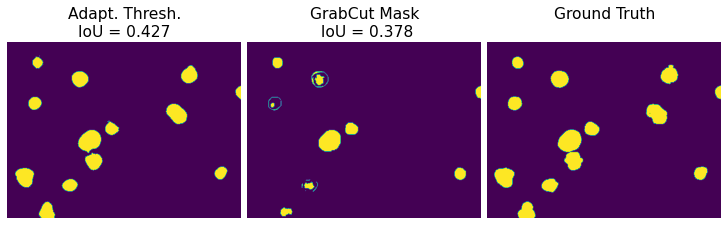

In [38]:
fig, axs = plt.subplots(1, 3, figsize=(10,10), constrained_layout=True)

axs[0].set_title(f'Adapt. Thresh.\nIoU = 0.427')
axs[0].imshow(masks['neurblas16']['computed_masks'][1])
axs[0].axis('off')

axs[1].set_title(f'GrabCut Mask\n IoU = 0.378')
axs[1].imshow(worst_seg.values[0])
axs[1].axis('off')

axs[2].set_title(f'Ground Truth\n ')
axs[2].imshow(neurblas16_gt)
axs[2].axis('off')

plt.savefig(f"plots/lowiougrabcut.png", bbox_inches='tight')
plt.savefig(f"plots_pdf/lowiougrabcut.pdf", format='pdf', bbox_inches='tight')

plt.show()

# Sample gallery of some masks for the same target image neurblas16

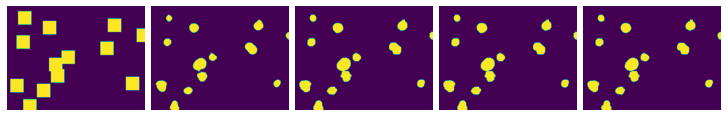

In [39]:
fig, axs = plt.subplots(1, 5, figsize=(10,10), constrained_layout=True)

axs[0].imshow(masks['neurblas16']['computed_masks'][0])
axs[0].axis('off')

axs[1].imshow(masks['neurblas16']['computed_masks'][1])
axs[1].axis('off')

axs[2].imshow(best_seg.values[0])
axs[2].axis('off')

axs[3].imshow(sitk.GetArrayFromImage(staple_eval_data['neurblas16']['staple_estimate']))
axs[3].axis('off')

axs[4].imshow(neurblas16_gt)
axs[4].axis('off')

plt.savefig(f"plots/maskcomparison.png", bbox_inches='tight')
plt.savefig(f"plots_pdf/maskcomparison.pdf", format='pdf', bbox_inches='tight')

plt.show()

# Sample view of some masks which disagree with each other

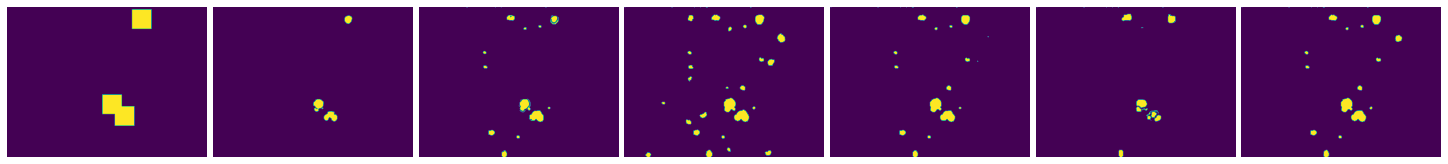

In [40]:
fig, axs = plt.subplots(1, 7, figsize=(20,10), constrained_layout=True)

axs[0].imshow(masks['agg185']['computed_masks'][0])
axs[0].axis('off')

axs[1].imshow(masks['agg185']['computed_masks'][1])
axs[1].axis('off')

axs[2].imshow(masks['agg185']['annotator_masks'][7])
axs[2].axis('off')

axs[3].imshow(masks['agg185']['annotator_masks'][20])
axs[3].axis('off')

axs[4].imshow(masks['agg185']['annotator_masks'][17])
axs[4].axis('off')

axs[5].imshow(masks['agg185']['annotator_masks'][3])
axs[5].axis('off')

axs[6].imshow(sitk.GetArrayFromImage(staple_eval_data['agg185']['staple_estimate']))
axs[6].axis('off')

plt.savefig(f"plots/agg185maskcomparison.png", bbox_inches='tight')
plt.savefig(f"plots_png_higher_res/agg185maskcomparison.png", dpi=1000, bbox_inches='tight')
plt.savefig(f"plots_pdf/agg185maskcomparison.pdf", format='pdf', bbox_inches='tight')

plt.show()